In [1]:
import os
import hashlib
from pathlib import Path
import argparse

import torch
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import BasePredictionWriter
import pandas as pd
import lightning.pytorch as pl
from FUCCIDataset import FUCCIDatasetInMemory, ReferenceChannelDatasetInMemory, FUCCIChannelDatasetInMemory
from LightningModules import AutoEncoder, FUCCIDataModule, MultiModalAutoencoder


import numpy as np
import multiscale_phate
import scprep
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
import wandb
import seaborn as sns

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024"
torch.set_float32_matmul_precision('medium')


from dataclasses import dataclass
@dataclass
class EmbeddingArgs:
    model: str
    channels: str
    data: str

args = EmbeddingArgs(
    # model="/data/ishang/fucci_vae/fucci_256_512_2023_05_24_05_47/",
    # channels="fucci",
    # model="/data/ishang/fucci_vae/FUCCI_reference_VAE_2023_06_07_11_56/",
    # channels="reference",
    model="/data/ishang/fucci_vae/FUCCI_all_VAE_2023_07_05_05_39/lightning_logs/97-16345635.00.ckpt",
    channels="all",
    data="/data/ishang/Fucci-dataset-v3_filtered/")
    # data="/home/ishang/implicit-cell-model/FUCCI-dev-data")

devices = 8

perm = None
flipped = False
view_variance = False

# Note that the index.csv might not be right, but we don't need it right now

if not Path(args.model).exists():
    raise ValueError("Checkpoint path does not exist.")
args.model = Path(args.model)
if not args.model.is_file():
    if args.model / "lightning_logs" in args.model.iterdir():
        args.model = args.model / "lightning_logs"
        if len(list(args.model.iterdir())) > 1:
            raise ValueError("Multiple model directories were found in lightning_logs.")
        else:
            args.model = list(args.model.iterdir())[0]
    else:
        raise ValueError("Model path does not contain lightning_logs directory.")

if not Path(args.data).exists():
    raise ValueError("Data path does not exist.")
args.data = Path(args.data)

if args.channels not in ["reference", "fucci", "total", "all"]:
    raise ValueError("Model must be one of: reference, fucci, total, all")

def img_hash(image):
    return hashlib.blake2b(image.numpy().tobytes()).hexdigest()


mu_file = args.data / (f"{args.channels}_mu" + ("flipped" if flipped else "") + ".pt")
logvar_file = args.data / (f"{args.channels}_logvar" + ("flipped" if flipped else "") + ".pt")
indices_file = args.data / (f"{args.channels}_indices" + ("flipped" if flipped else ""))
colors_file = args.data / "colors"

In [3]:
# Do I ever use a cache again?????

if args.data / "index.csv" not in args.data.iterdir():
    if args.channels == "reference":
        dataset = ReferenceChannelDatasetInMemory(args.data, imsize=256)
    elif args.channels == "fucci":
        dataset = FUCCIChannelDatasetInMemory(args.data, imsize=256)
    else:
        dataset = FUCCIDatasetInMemory(args.data, imsize=256)
    cache = []
    for i in range(len(dataset)):
        exp_dir, cell_index = dataset.image_exp_index(i)
        cache.append({
            "index": i,
            "hash": img_hash(dataset[i]),
            "directory": str(exp_dir[1]),
            "cell_index": cell_index
        })
    cache = pd.DataFrame(cache)
    cache.to_csv(args.data / "index.csv")

else:
    cache = pd.read_csv(args.data / "index.csv")

In [4]:
# dataset = FUCCIDatasetInMemory(args.data, imsize=256)
# dataset[0].shape
# len(dataset)
# # fucci_mag = torch.sum(dataset[:, ]

In [5]:
# fucci_images = dataset[:, 2:]
# fucci_mag = torch.sum(fucci_images, dim=(1, 2, 3))
# fucci_colors = torch.sum(fucci_images, dim=(2, 3)) # TODO: this should be averaged over the nucleus mask
# fucci_diff = fucci_colors[:, 1] - fucci_colors[:, 0]
# fucci_level = fucci_diff / fucci_mag


In [6]:
# plt.clf()
# plt.scatter(torch.log(fucci_colors[:, 0]), torch.log(fucci_colors[:, 1]), c=fucci_level, cmap="RdYlGn")
# plt.show()
# plt.clf()
# plt.scatter(fucci_level, torch.log(fucci_mag))
# plt.show()
# plt.clf()
# plt.hist(fucci_level)
# plt.show()

In [7]:
dm = FUCCIDataModule(args.data, args.channels, imsize=256, batch_size=8, num_workers=1, in_memory=True)

In [8]:
if args.channels == "all":
    model = MultiModalAutoencoder.load_from_checkpoint(args.model)
else:
    model = AutoEncoder.load_from_checkpoint(args.model)

adding channel DAPI
adding channel gamma-tubulin
adding channel Geminin
adding channel CDT1


In [9]:
predict_dm = dm

In [10]:
class CustomWriter(BasePredictionWriter):

    def __init__(self, output_dir, write_interval):
        super().__init__(write_interval)
        self.output_dir = output_dir

    def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
        # this will create N (num processes) files in `output_dir` each containing
        # the predictions of it's respective rank
        print(predictions.shape)
        torch.save(predictions, os.path.join(self.output_dir, f"predictions_{trainer.global_rank}.pt"))

        # optionally, you can also save `batch_indices` to get the information about the data index
        # from your prediction data
        torch.save(batch_indices, os.path.join(self.output_dir, f"batch_indices_{trainer.global_rank}.pt"))

In [14]:
pred_writer = CustomWriter(output_dir=args.data, write_interval="epoch")
trainer = pl.Trainer(accelerator="gpu", devices=devices, callbacks=[pred_writer], max_epochs=1)
model.set_predict_mode("embedding")
# model.to("cuda:0")
# print(model.device)
if args.channels == "all":
# if False:
    with torch.no_grad():
        model.eval()
        mus = None
        logvar = None
        for batch in iter(predict_dm.train_dataloader()):
            if not mus is None and mus[0].shape[0] > 1000:
                break
            # batch has shape B x C x H x W
            mu, logvar = model.forward_embedding(batch)
            # mu/logvar are C x B x latent
            if mus is None:
                mus = mu
                logvars = logvar
                continue
            for i in range(len(mu)):
                mus[i] = torch.concat((mus[i], mu[i]))
                logvars[i] = torch.concat((logvars[i], logvar[i]))
        model.train()
        mus = torch.stack(mus)
        logvars = torch.stack(logvars)
        # mus/logvars is C x B x latent
else:
    trainer.predict(model, datamodule=predict_dm, return_predictions=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


torch.Size([8, 512])
torch.Size([16, 512])
torch.Size([24, 512])
torch.Size([32, 512])
torch.Size([40, 512])
torch.Size([48, 512])
torch.Size([56, 512])
torch.Size([64, 512])
torch.Size([72, 512])
torch.Size([80, 512])
torch.Size([88, 512])
torch.Size([96, 512])
torch.Size([104, 512])
torch.Size([112, 512])
torch.Size([120, 512])
torch.Size([128, 512])
torch.Size([136, 512])
torch.Size([144, 512])
torch.Size([152, 512])
torch.Size([160, 512])
torch.Size([168, 512])
torch.Size([176, 512])
torch.Size([184, 512])
torch.Size([192, 512])
torch.Size([200, 512])
torch.Size([208, 512])
torch.Size([216, 512])
torch.Size([224, 512])
torch.Size([232, 512])
torch.Size([240, 512])
torch.Size([248, 512])
torch.Size([256, 512])
torch.Size([264, 512])
torch.Size([272, 512])
torch.Size([280, 512])
torch.Size([288, 512])
torch.Size([296, 512])
torch.Size([304, 512])
torch.Size([312, 512])
torch.Size([320, 512])
torch.Size([328, 512])
torch.Size([336, 512])
torch.Size([344, 512])
torch.Size([352, 512])
t

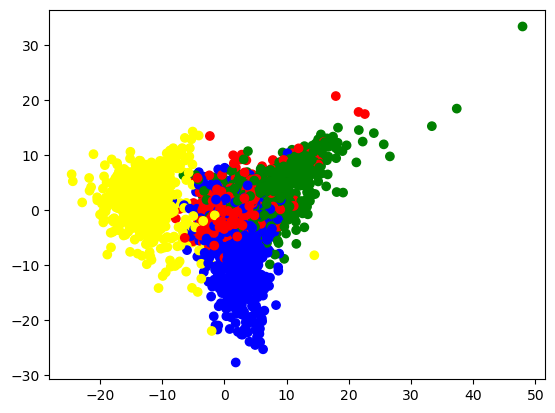

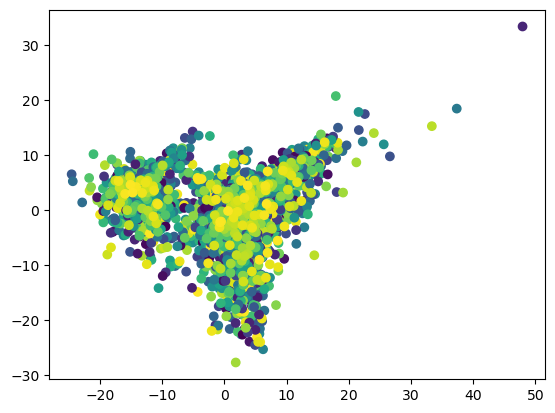

In [15]:
# do a PCA visualization of the data and color by the channel, then show same plot colored by sample
if args.channels == "all":
    channels = dm.get_channels()
    colors = ["blue", "yellow", "green", "red"]
    pca = PCA(n_components=2)
    data_gpu = torch.clone(mus)
    data_gpu = data_gpu.transpose(0, 1).reshape(-1, mus.shape[2])
    data = data_gpu.cpu().numpy()
    pca.fit(data)
    transformed = pca.transform(data)

    plt.clf()
    plt.scatter(transformed[:, 0], transformed[:, 1], c=[i % len(colors) for i in range(transformed.shape[0])], cmap=matplotlib.colors.ListedColormap(colors))
    plt.show()
    plt.clf()
    plt.scatter(transformed[:, 0], transformed[:, 1], c=[i % mus.shape[1] for i in range(transformed.shape[0])])
    plt.show()
else:
    pass

In [ ]:
# Now do it with UMAP


In [ ]:
predictions = []
batch_indices = []
for i in range(devices):
    predictions.append(torch.load(args.data / f"predictions_{i}.pt"))
    batch_indices.append(torch.load(args.data / f"batch_indices_{i}.pt")[0])

def flatten_one(l):
    return [item for sublist in l for item in sublist]

print(len(predictions), len(predictions[0]))
print(len(batch_indices))

predictions = flatten_one(predictions)
batch_indices = flatten_one(batch_indices)
print(len(predictions), len(predictions[0]))
print(len(batch_indices))

mu_predictions = [prediction[0] for prediction in predictions]
var_predictions = [prediction[1] for prediction in predictions]
print(len(mu_predictions), len(var_predictions))

mu_predictions = flatten_one(mu_predictions)
var_predictions = flatten_one(var_predictions)
batch_indices = flatten_one(batch_indices)
print(len(mu_predictions), len(var_predictions))
print(len(batch_indices))

In [ ]:
mu = torch.stack(mu_predictions)
var = torch.stack(var_predictions)
indices = batch_indices
print(batch_indices)
print(mu.shape, var.shape, len(indices))
print(mu.min(), mu.max())
print(var.min(), var.max())

index_map = [0] * len(indices)
for i in indices:
    index_map[indices[i]] = i

torch.save(mu[index_map], mu_file)
torch.save(var[index_map], logvar_file)
torch.save(indices, indices_file)

print([indices[i] for i in index_map])

In [ ]:
# remove the batch_indices_*.pt and predictions_*.pt files
for i in range(devices):
    os.remove(args.data / f"predictions_{i}.pt")
    os.remove(args.data / f"batch_indices_{i}.pt")

In [ ]:
# compute original colors
dataset = FUCCIDatasetInMemory(args.data, imsize=256)

In [ ]:
colors = dataset[:].numpy()
print(colors.shape)
colors = colors[:, 2:, :, :]
color_mag = np.sum(colors, axis=(1, 2, 3))
colors = np.sum(colors[:, 0, :, :] - colors[:, 1, :, :], axis=(1, 2)) / color_mag
# colors = np.sum(colors[:, 0, :, :] - colors[:, 1, :, :], axis=(1, 2))
# colors = np.sign(colors) * np.log(np.abs(colors) + 1e-8)
print(colors.min(), colors.max())

plt.clf()
plt.hist(colors, bins=100)
plt.show()
plt.clf()

plt.clf()
plt.hist(np.log(color_mag), bins=100)
plt.show()
plt.clf()

np.save(colors_file, colors)

In [ ]:
def PCA_plot(predictions, message="", sample=None):
    # select random elements and do PCA
    if sample is None:
        sample = len(predictions)
    indices = np.random.choice(len(predictions), sample)
    embeddings_slice = predictions[indices, :].numpy()
    num_components = embeddings_slice.shape[1]
    print(f"Using {num_components} components for PCA")
    pca = PCA(n_components=num_components)
    pca.fit(embeddings_slice)
    # print(pca.explained_variance_ratio_[:10])
    # print(pca.singular_values_)
    # print(pca.components_.shape)
    # print the number of components needed to have 95% of the variance
    print(f"Number of components needed to have 95% of the variance: {1+np.argmax(np.cumsum(pca.explained_variance_ratio_) > 0.95)}")

    # plot the first 2 components
    plt.clf()
    plt.title(f"PCA of FUCCI {args.channels} embeddings {message}")
    plt.scatter(pca.components_[0], pca.components_[1])
    plt.show()

    plt.clf()
    fig, ax = plt.subplots()
    plt.title(f"Bar chart of FUCCI {args.channels} PCA components CDF {message}")
    plt.bar(range(len(pca.explained_variance_ratio_)), np.cumsum(pca.explained_variance_ratio_))
    ax.axhline(y=0.95, color='r')
    plt.show()
    return pca

In [ ]:
input_entity = mu
pca = PCA_plot(input_entity, message="")

In [ ]:
def PHATE_fit(embeddings, sample=None, message=""):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    if sample is not None:
        indices = np.random.choice(len(embeddings), sample)
        embeddings = embeddings[indices]
    mp_op = multiscale_phate.Multiscale_PHATE()
    return mp_op.fit_transform(embeddings)

def PHATE_plot(mp_embedding, mp_sizes, mp_clusters, message=""):
    scprep.plot.scatter2d(mp_embedding, s=mp_sizes, c=mp_clusters,
                          fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10, 10))

In [ ]:
# script to compute PHATE levels, get embeddings separately, and add colors
# can pull this from the github
mp_op = multiscale_phate.Multiscale_PHATE()
indices = np.random.choice(len(predictions), 2000)
embeddings_slice = input_entity[indices, :].numpy()
colors_slice = colors[indices]
levels = mp_op.fit(embeddings_slice)
mp_embedding, mp_clusters, mp_sizes = mp_op.transform(visualization_level = levels[0],
                                                                  cluster_level = levels[0])
scprep.plot.scatter2d(mp_embedding, cmap="RdYlGn", c=colors_slice, fontsize=16, ticks=False, label_prefix="Multiscale PHATE", figsize=(10,10))

In [ ]:
phate_output = PHATE_fit(input_entity, sample=1000)
PHATE_plot(*phate_output, message="")

In [ ]:
# plot UMAP

import umap
import umap.plot

indices = np.random.choice(len(input_entity), 4000)
embeddings_slice = input_entity[indices, :].numpy()
colors_slice = colors[indices]
umap_embedding = umap.UMAP().fit(embeddings_slice)
# umap.plot.points(umap_embedding)

# plot gradient of red to green for small to large
umap.plot.points(umap_embedding, values=colors_slice, cmap="RdYlGn")

In [ ]:
print(pca.components_.shape)
print(embeddings_slice.shape)
pc_embeddings = np.matmul(pca.components_, embeddings_slice.T)
print(pc_embeddings.shape)

num_points = 100
for i in range(5):
    plt.clf()
    fig = sns.regplot(x=pc_embeddings[i], y=colors_slice)
    plt.show()

In [ ]:
# Plot each variable in the embedding vector against the color and give the R^2 value of the correlation
import seaborn as sns

print(embeddings_slice.shape)
print(type(embeddings_slice), type(colors_slice))
num_points = 100
for i in range(5):
    plt.clf()
    fig = sns.regplot(x=embeddings_slice[:, i],
                y=colors_slice)
    plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(pc_embeddings.T[:800, :10], colors_slice[:800])
print(reg.score(pc_embeddings.T[800:, :10], colors_slice[800:]))
print(reg.coef_)

In [ ]:
# train logistic regression classifier on binarized colors
from sklearn.linear_model import LogisticRegression
reg = LogisticRegression(max_iter=1000)
reg.fit(pc_embeddings.T[:800, :10], colors_slice[:800] > 0)
print(reg.score(pc_embeddings.T[800:, :10], colors_slice[800:] > 0))